In [1]:
using Turing, Plots, LinearAlgebra, Distributions

In [2]:
#Generate data
using Random
import Distributions: pdf, MvNormal, rand

Random.seed!(1) # Set random seed

T = 40 # Number of timepoints

# Generative parameters
mu_0 = [8.0, 1.0] # Prior mean
V_0 = diagm(0=>ones(2)) # Prior covariance; diageye ensures an identity matrix of Diagonal type
F = [1.0 0.2; 
     -0.5 0.8] # Process matrix
H = [1.0 0.0; 
     0.0 1.0] # Observation matrix
Q = 1e-2*diagm(0=>ones(2)) # Process noise covariance
R = 1e-1*diagm(0=>ones(2)) # Observation noise covariance

# Data
x_hat = Vector{Vector{Float64}}(undef, T)
y_hat = Vector{Vector{Float64}}(undef, T)
prior_x = MvNormal(mu_0, V_0)
process_noise_dist = MvNormal(zeros(2), Q)
obs_noise_dist = MvNormal(zeros(2), R)

x_hat[1] = rand(prior_x)
y_hat[1] = H*x_hat[1] + rand(obs_noise_dist)
for t = 2:T
    x_hat[t] = F*x_hat[t-1] + rand(process_noise_dist) # Execute process
    y_hat[t] = H*x_hat[t] + rand(obs_noise_dist) # Draw observation
end
;

In [3]:
@model function BLDS(y)
    # Generative parameters
    mu_0 = [8.0, 1.0] # Prior mean
    V_0 = diagm(0=>ones(2)) # Prior covariance; diageye ensures an identity matrix of Diagonal type
    F = [1.0 0.2; 
         -0.5 0.8] # Process matrix
    H = [1.0 0.0; 
         0.0 1.0] # Observation matrix
    Q = 1e-2*diagm(0=>ones(2)) # Process noise covariance
    R = 1e-1*diagm(0=>ones(2)) # Observation noise covariance
    T = 40 # Number of timepoints
    
    # Priors
    a_prior ~ MvNormal(zeros(4),diagm(0=>ones(4)))
    x = Vector{Vector}(undef,T)
    x[1] ~ MvNormal(mu_0, V_0)
    
    y[1] ~ MvNormal(H*x[1], R) # Observation model
    
    for t = 2:T
        x[t] ~ MvNormal(reshape(a_prior,(2,2))*x[t-1], Q) # Process model
        y[t] ~ MvNormal(H*x[t], R) # Observation model
    end
end

BLDS (generic function with 1 method)

In [4]:
chain = sample(BLDS(y_hat), NUTS(100,0.65), 50)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/sakbayrak/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:17


Chains MCMC chain (50×96×1 Array{Float64,3}):

Iterations        = 1:50
Thinning interval = 1
Chains            = 1
Samples per chain = 50
parameters        = a_prior[1], a_prior[2], a_prior[3], a_prior[4], x[1][1], x[1][2], x[2][1], x[2][2], x[3][1], x[3][2], x[4][1], x[4][2], x[5][1], x[5][2], x[6][1], x[6][2], x[7][1], x[7][2], x[8][1], x[8][2], x[9][1], x[9][2], x[10][1], x[10][2], x[11][1], x[11][2], x[12][1], x[12][2], x[13][1], x[13][2], x[14][1], x[14][2], x[15][1], x[15][2], x[16][1], x[16][2], x[17][1], x[17][2], x[18][1], x[18][2], x[19][1], x[19][2], x[20][1], x[20][2], x[21][1], x[21][2], x[22][1], x[22][2], x[23][1], x[23][2], x[24][1], x[24][2], x[25][1], x[25][2], x[26][1], x[26][2], x[27][1], x[27][2], x[28][1], x[28][2], x[29][1], x[29][2], x[30][1], x[30][2], x[31][1], x[31][2], x[32][1], x[32][2], x[33][1], x[33][2], x[34][1], x[34][2], x[35][1], x[35][2], x[36][1], x[36][2], x[37][1], x[37][2], x[38][1], x[38][2], x[39][1], x[39][2], x[40][1], x[40][2]
internals   

In [5]:
group(chain,:a_prior)

Chains MCMC chain (50×4×1 Array{Float64,3}):

Iterations        = 1:50
Thinning interval = 1
Chains            = 1
Samples per chain = 50
parameters        = a_prior[1], a_prior[2], a_prior[3], a_prior[4]
internals         = 

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat 
      Symbol   Float64   Float64    Float64   Missing   Float64   Float64 

  a_prior[1]    1.0141    0.0082     0.0012   missing   82.9503    0.9798
  a_prior[2]   -0.4908    0.0109     0.0015   missing   30.3204    0.9909
  a_prior[3]    0.2087    0.0061     0.0009   missing   60.0173    0.9798
  a_prior[4]    0.7958    0.0060     0.0008   missing   31.0002    1.0129

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

  a_prior[1]    0.9989    1.0099    1.0142    1.0190    1.0281
  a_prior[2]   -0.5139   -0.4949   -0.4913   -0.4833   -0.4741
  a_prior[3]    0.1976    0.2044    0.208

In [6]:
mean(group(chain,:a_prior).value.data, dims=1)

1×4×1 Array{Float64,3}:
[:, :, 1] =
 1.01406  -0.490842  0.208709  0.795834

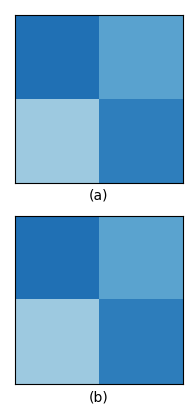

In [7]:
F_est = reshape(mean(group(chain,:a_prior).value.data, dims=1),(2,2))

using PyPlot
fig = figure()
g, axes = subplots(nrows=2, ncols=1)
fs = [F_est, F]
titles = ["(a)", "(b)"]

for (i,ax) in enumerate(axes)
    img = ax.matshow(fs[i], cmap="Blues", vmin=-2.0, vmax=2.0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(titles[i])
end